# Chapter 9: Dimensionality Reduction

In [ ]:
%matplotlib inline
low_memory=False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

Nothing done.


## 9.1 Introduction & Motivation

We've seen quite a few regression, classification, and clustering methods. That's great! We can already train many different models and gain insights from them. However, now it's time to take a step back and look at the data we are feeding our models. Instead of just throwing everything we have at it, we are going to reduce our data by performing **Principal Component Analysis (PCA)**.

Why do we do this? When working with large datasets, training a model becomes more complex and computationally expensive. For example, think of the training process of a GPT model. The more data being used, the more time it will take to train and the more CPU power it will consume, requiring expensive machinery and driving up electricity bills significantly. However, we still want to retain most of the information contained in our data. That's where PCA comes into play. We reduce data by transforming it into a smaller set of core components while preserving the most important information.

- Can reduce noise in the data

**Key Benefits of PCA:**- Helps visualize high-dimensional data

- Reduces computational complexity- Reduces storage requirements
- Speeds up training time

## 9.2 Problem Setting

The faces dataset is a useful dataset for exploring the differences between models and the effects of dimensionality reduction techniques. This makes it a prime candidate for exploring PCA!

Similar to the digits dataset, it contains a collection of images and their corresponding labels. This time, however, the images are not handwritten digits but faces of famous American politicians. Let's explore the dataset and discover what we can achieve with PCA!

- Real-world application of dimensionality reduction

**Dataset Overview:**- High-dimensional data perfect for demonstrating PCA

- Contains facial images of politicians- Each image has multiple pixel values (features)

## 9.3 Model

First, let's have a look at the data.

**Hint:** Pay attention to the shape of the data. This will help you understand how many features (dimensions) we're working with and how PCA can reduce this complexity.

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


##### Question 1: By now you should be familiar with the digits dataset. Visualize the faces dataset in a similar way. Show only the first 5 faces. Can you display the correct name as labels?

- Consider using a grayscale colormap for better visualization

**Hints:**- Use `target_names[label]` to get the actual person's name

- Use `plt.subplot()` to create multiple plots in one figure- The image data needs to be reshaped to display properly (check the image shape from above)

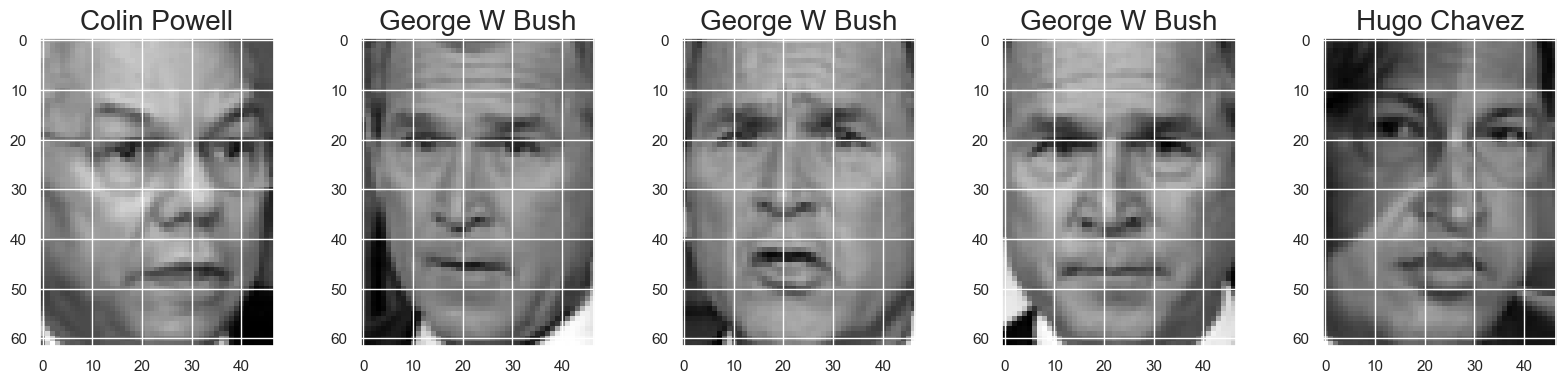

In [3]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(faces.data[0:5], faces.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (62,47)), cmap=plt.cm.gray)
    plt.title(faces.target_names[label], fontsize = 20)
plt.show()

##### Question 2: Train a classification method of your choice to get some predictions. Use cross-validation to get the best results. Remember to select the best parameters!

- This baseline performance will be important for comparing with PCA results later

**Hints:**- Plot the accuracy vs. parameter values to visualize the best choice

- KNN is a good choice for image classification- Use train-test split to evaluate different parameter values
- Try different values of k (number of neighbors) to find the optimal parameter

c:\Users\billo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\billo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\billo\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\billo\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

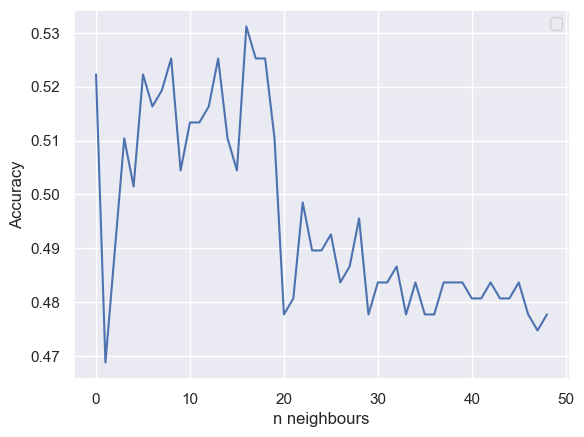

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.25, random_state=0)

accuracies = []
for n in range (1, 50):
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(accuracies)
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

C:\Users\billo\AppData\Local\Temp\ipykernel_28356\2971677063.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


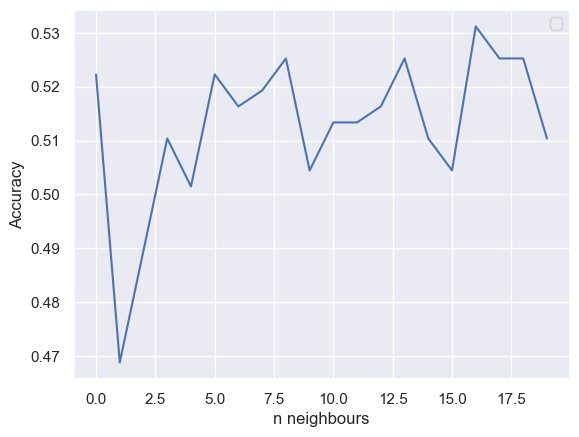

In [5]:
plt.plot(accuracies[:20])
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We get the highest accuracy around index 16, which corresponds to a k value of 17 (since our range starts at 1).

In [6]:
from sklearn.model_selection import KFold, cross_val_score

knn = KNeighborsClassifier(n_neighbors = 17)
k_folds = KFold(n_splits = 10)
scores_knn_acc = cross_val_score(knn, faces.data, faces.target, cv = k_folds)
print("Knn CV Accuracy Score: ", scores_knn_acc.mean())

Knn CV Accuracy Score:  0.5571254836926478


Using our KNN model, we get an accuracy score of 0.56, or 56%. This means just over half of our predictions are correct.

**Note:** This baseline accuracy will serve as our comparison point when we apply PCA to see how dimensionality reduction affects model performance.

## 9.4 Model Evaluation

##### Question 3: It's time to reduce our data using PCA! Figure out the best amount of principal components and reduce the data.

- Look for the point where the slope significantly decreases

**Hints:**- Remember: each eigenvalue represents how much variance that component explains

- Start by fitting PCA without specifying the number of components to see all eigenvalues- The elbow method helps identify where additional components provide diminishing returns
- Plot the explained variance ratio (eigenvalues) to visualize the "elbow"

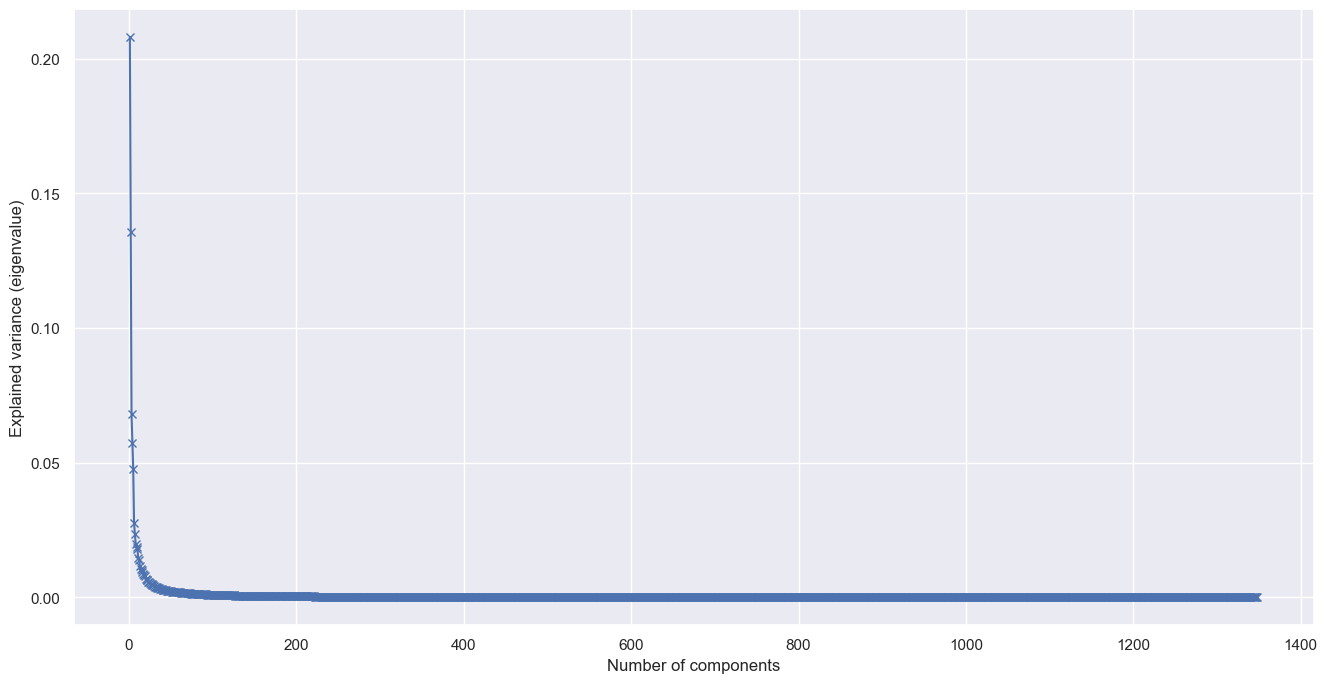

In [7]:
pca = PCA().fit(faces.data)
plt.figure(figsize=(16,8))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bx-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eigenvalue)')
plt.show()

Because our number of variables is so high and our data contains many variables with low variance, our elbow is hard to interpret. To solve this, we are going to zoom in on the first 100 components.

**Why zoom in?** With 1,348 original features, the plot becomes cluttered. The first few components typically capture most of the variance, so focusing on the first 100 gives us a clearer view of the elbow.

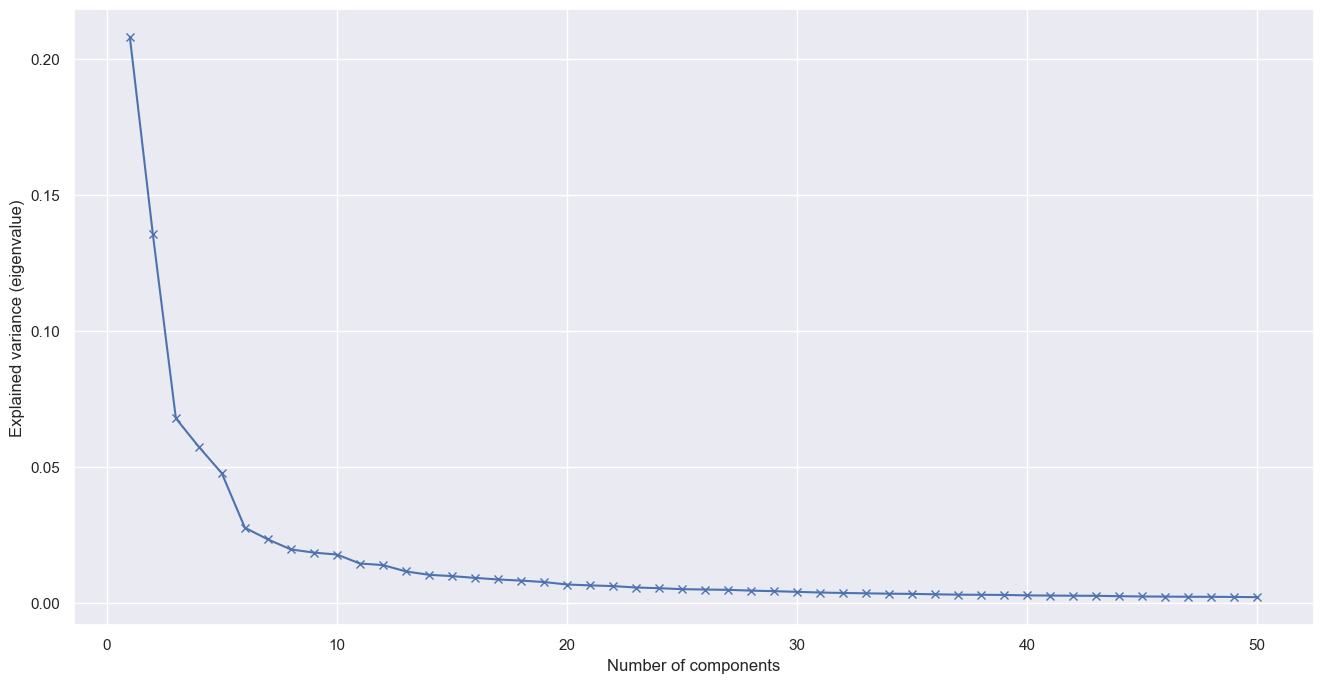

In [151]:
plt.figure(figsize=(16,8))
plt.plot(range(1, 51), pca.explained_variance_ratio_[:50], 'bx-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eigenvalue)')
plt.show()

It seems like our optimal number of principal components is somewhere around 6. Remember that we started with 1,348 variables - this is a reduction of almost 99%!

**Amazing efficiency:** We can potentially retain most of the important information using less than 1% of the original features!

##### Question 4: Do you notice something special about the eigenvalues? What is the total sum of all eigenvalues? Play around with models with different amounts of components. How does this change? Is this expected? Elaborate based on the meaning of eigenvalue.

- Consider what happens when you include ALL components vs. just a subset

**Hints:**- Remember: eigenvalues represent the proportion of total variance explained by each component

- Calculate the sum of explained variance ratios for different numbers of components- Think about what 100% variance means in the context of the original data

In [152]:
print('Sum of all eigenvalues:', sum(pca.explained_variance_ratio_))

Sum of all eigenvalues: 0.9500136


We can see that the total sum of all eigenvalues is almost exactly one. This might be a coincidence, or it might be that the actual sum is one and we get this small difference due to rounding errors. Let's explore this further.

**Key Insight:** The sum of all eigenvalues should theoretically equal 1.0 because they represent proportions of the total variance.

In [168]:
pca1000 = PCA(1000)
pca100 = PCA(100)
pca16 = PCA(16)
pca6 = PCA(6)
pca1 = PCA(1)

pca1000.fit(faces.data)
pca100.fit(faces.data)
pca16.fit(faces.data)
pca6.fit(faces.data)
pca1.fit(faces.data)

print('Sum of all eigenvalues (1000):', sum(pca1000.explained_variance_ratio_))
print('Sum of all eigenvalues (100):', sum(pca100.explained_variance_ratio_))
print('Sum of all eigenvalues (16):', sum(pca16.explained_variance_ratio_))
print('Sum of all eigenvalues (6):', sum(pca6.explained_variance_ratio_))
print('Sum of all eigenvalues (1):', sum(pca1.explained_variance_ratio_))

Sum of all eigenvalues (1000): 0.9993424
Sum of all eigenvalues (100): 0.9039676
Sum of all eigenvalues (16): 0.69354993
Sum of all eigenvalues (6): 0.5442094
Sum of all eigenvalues (1): 0.20798308


We notice that the fewer components we consider, the lower our sum becomes. In a way, this is expected because we are adding fewer values together.

**Understanding Eigenvalues:**
- The eigenvalue of a component explains exactly how much variance of the total dataset is explained by that component
- The more components we add to our sum, the more variance of our model gets explained

- This explains why the sum is 0.21 for only one component, as we can see this exact value in the graph above - this component contains 21% of all variance in our data**Practical Implication:** This mathematical property helps us choose how many components to keep based on how much variance we want to preserve (e.g., 90%, 95%, 99%).


**Key Takeaway:** The total sum of 1 was no coincidence. If we take the sum of all components, we account for all the variance in our data, which represents 100% of the total variance.

##### Question 5: Use PCA and the best amount of components you found earlier to reduce your data. Retrain your model using kfold and compare the accuracy. What do you notice?

In [183]:
pca = PCA(16)
projected = pca.fit_transform(faces.data)
print(projected.shape)

(1348, 16)


C:\Users\billo\AppData\Local\Temp\ipykernel_28356\3430769751.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


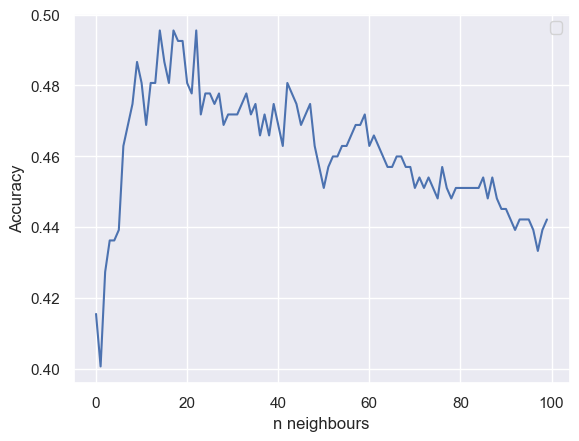

In [184]:
X_train, X_test, y_train, y_test = train_test_split(projected, faces.target, test_size=0.25, random_state=0)

accuracies = []
for n in range (1, 101):
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(accuracies)
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

C:\Users\billo\AppData\Local\Temp\ipykernel_28356\2652124515.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


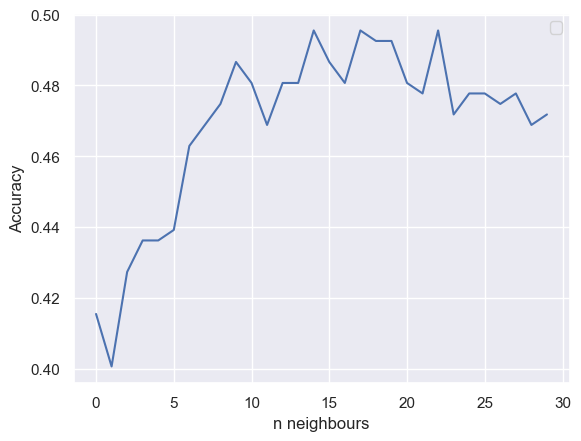

In [185]:
plt.plot(accuracies[:30])
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [186]:
from sklearn.model_selection import KFold, cross_val_score

knn = KNeighborsClassifier(n_neighbors = 18)
k_folds = KFold(n_splits = 10)
scores_knn_acc = cross_val_score(knn, projected, faces.target, cv = k_folds)
print("Knn CV Accuracy Score: ", scores_knn_acc.mean())

Knn CV Accuracy Score:  0.503681592039801


Our accuracy score has decreased by 5%! It's important to evaluate whether this is good or bad in context.

**Real-world consideration:** In many applications, this trade-off is excellent - you get almost the same performance with dramatically reduced computational costs.

**Trade-off Analysis:**

- **Downside:** We dropped from 56% to 51% accuracy, which seems significant- The model is now much more interpretable with only 16 dimensions

- **Upside:** We reduced our data size by 99% (from 1,348 to 16 features) and only lost 5% accuracy!- Significantly reduced storage requirements

- Much faster training and prediction times

**Why this is impressive:**- Massive reduction in computational complexity

##### Question 6: Your department just got granted some extra budget. You are able to use some more processing power, but still not enough to use the entire dataset. Your boss wants you to create a model that retains 90% of all variance. Create this model and calculate the accuracy as before. By how much did you reduce the size of your dataset?

- Calculate the percentage reduction: `(original_features - new_features) / original_features * 100`

**Hints:**- Compare the number of components used with the original 1,348 features

- You can specify the variance ratio directly in PCA: `PCA(0.9)`- This will automatically determine how many components are needed to retain 90% of variance

In [187]:
pca = PCA(0.9)
projected = pca.fit_transform(faces.data)
print(projected.shape)

(1348, 96)


C:\Users\billo\AppData\Local\Temp\ipykernel_28356\3430769751.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


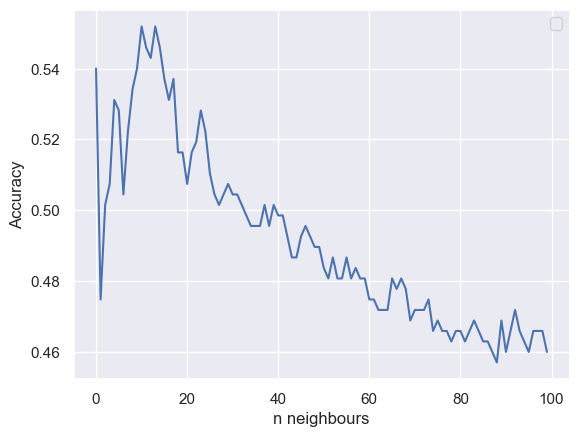

In [188]:
X_train, X_test, y_train, y_test = train_test_split(projected, faces.target, test_size=0.25, random_state=0)

accuracies = []
for n in range (1, 101):
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(accuracies)
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

C:\Users\billo\AppData\Local\Temp\ipykernel_28356\2971677063.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


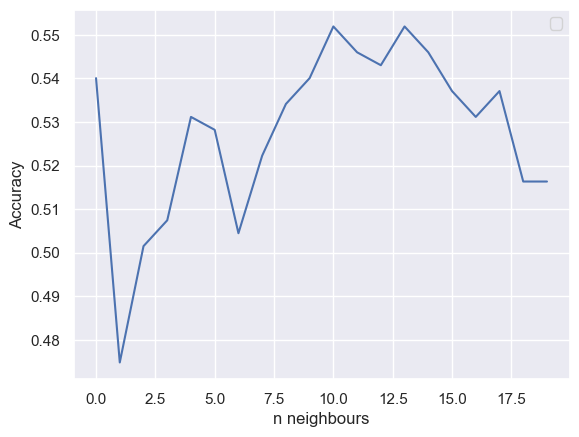

In [189]:
plt.plot(accuracies[:20])
plt.xlabel("n neighbours")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [190]:
from sklearn.model_selection import KFold, cross_val_score

knn = KNeighborsClassifier(n_neighbors = 11)
k_folds = KFold(n_splits = 10)
scores_knn_acc = cross_val_score(knn, projected, faces.target, cv = k_folds)

print("Knn CV Accuracy Score: ", scores_knn_acc.mean())

n_components = pca.n_components_
print("Data size reduction", 100 * (1348 - n_components) / 1348, "%")

Knn CV Accuracy Score:  0.5697788833609729
Data size reduction 92.87833827893175 %


Now look at that! Our accuracy score has even improved compared to our original model, while our number of variables has decreased by 92%! Your boss will definitely be happy! 😊

**Key Learning:** Sometimes PCA doesn't just reduce complexity - it can actually improve performance by removing noisy, irrelevant features that confuse the classifier!

**Excellent Results Analysis:**

- **Accuracy improvement:** Better than the original 56%- **Why this works:** By retaining 90% of variance, we keep the most important information while filtering out noise
- **Massive efficiency gain:** 92% reduction in features

## 9.5 Exercises

##### Question 1: See section 9.3
##### Question 2: See section 9.3
##### Question 3: See section 9.4
##### Question 4: See section 9.4
##### Question 5: See section 9.4
##### Question 6: See section 9.4
##### Question 7: PCA is used to reduce the number of variables by creating new variables that explain multiple previous ones. By definition, you should get somewhat usable results when reversing this process. Transform your projected data from Question 6 back into the original number of dimensions and compare the data by looking at the data points of the first face.

- This process demonstrates that PCA preserves the most important information

**Hints:**- The reconstructed data won't be identical but should be very similar

- Use `pca.inverse_transform()` to reconstruct the original data- Compare the original `faces.data[0]` with the reconstructed version

In [191]:
pca = PCA(0.9)
projected = pca.fit_transform(faces.data)
reconstructed = pca.inverse_transform(projected)

print("Original:", faces.data[0])
print("Reconstructed:", reconstructed[0])

Original: [0.53333336 0.52418303 0.49673203 ... 0.00653595 0.00653595 0.00130719]
Reconstructed: [0.50381523 0.51597476 0.5117188  ... 0.05889866 0.0469951  0.01681542]


While we do see some slight changes, overall the data has remained remarkably similar!

- The reconstruction quality validates our PCA approach

**What this demonstrates:**- This 10% was likely noise or less important details

- PCA successfully preserved the most important information- The differences represent the 10% of variance we chose to discard

##### Question 8: Now that you have figured out the process of reversing PCA, visualize the reconstructed data. Compare the reconstructed faces with the original ones and behold the true power of PCA!

- Some fine details might be slightly blurred (this is the 10% variance we discarded)

**Instructions:**- Key facial features should remain recognizable

- Create side-by-side visualizations: original faces vs. reconstructed faces- Overall facial structure should be well preserved

- Use the same visualization code from Question 1**What to look for:**

- Apply PCA with 90% variance, then use inverse_transform
- Compare how well the faces are preserved despite the massive dimensionality reduction

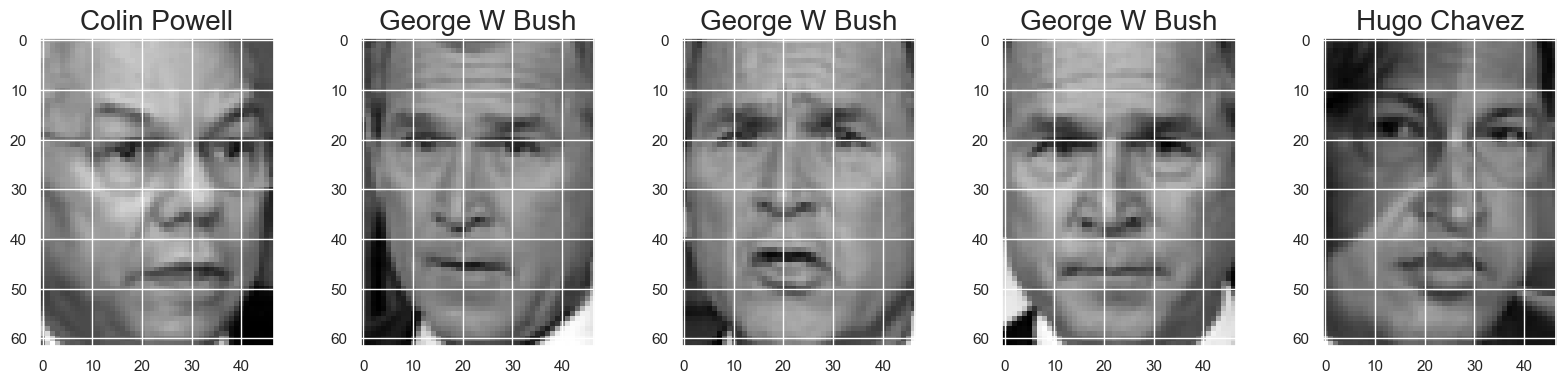

In [192]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(faces.data[0:5], faces.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (62,47)), cmap=plt.cm.gray)
    plt.title(faces.target_names[label], fontsize = 20)

plt.show()

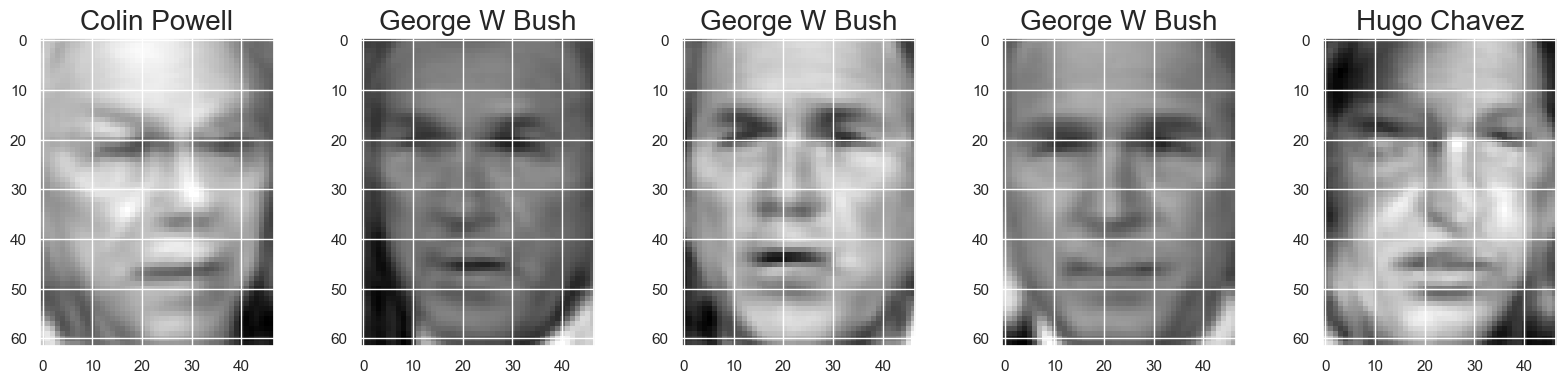

In [193]:
pca = PCA(0.9)
projected = pca.fit_transform(faces.data)
reconstructed = pca.inverse_transform(projected)

plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(reconstructed[0:5], faces.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (62,47)), cmap=plt.cm.gray)
    plt.title(faces.target_names[label], fontsize = 20)
plt.show()

##### Question 9: We talked briefly about how PCA can be used to reduce noise. Assume the 'noisy' data as seen below. Plot the faces as you did before to visually see the noise. What's the best result you can achieve when using PCA to reduce the noise?

**Try different variance thresholds:** Test 90%, 95%, 99% to see which gives the best noise reduction while preserving facial features.

**Experiment Design:**

1. First, visualize the noisy data to see the effect of added noise**Key Insight:** PCA learns patterns from clean data and can filter out noise when reconstructing because noise typically has low variance and gets captured in the discarded components.

2. Apply PCA to the original clean data (not the noisy data)

3. Use inverse_transform to reconstruct the data4. Compare: Original → Noisy → PCA-reconstructed

In [194]:
np.random.seed(42)
noisy = np.random.normal(faces.data, 0.1)

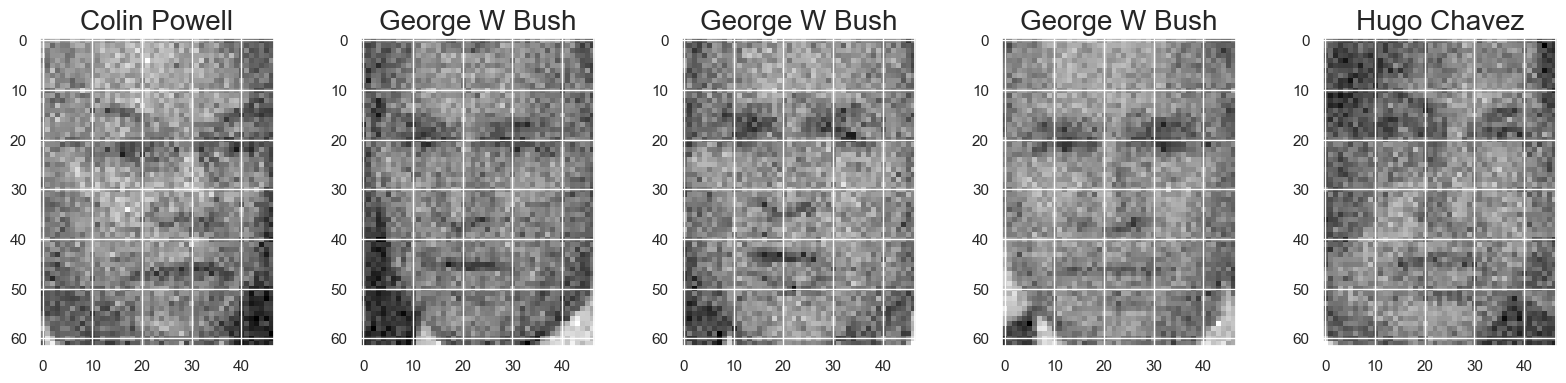

In [195]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(noisy[0:5], faces.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (62,47)), cmap=plt.cm.gray)
    plt.title(faces.target_names[label], fontsize = 20)
plt.show()

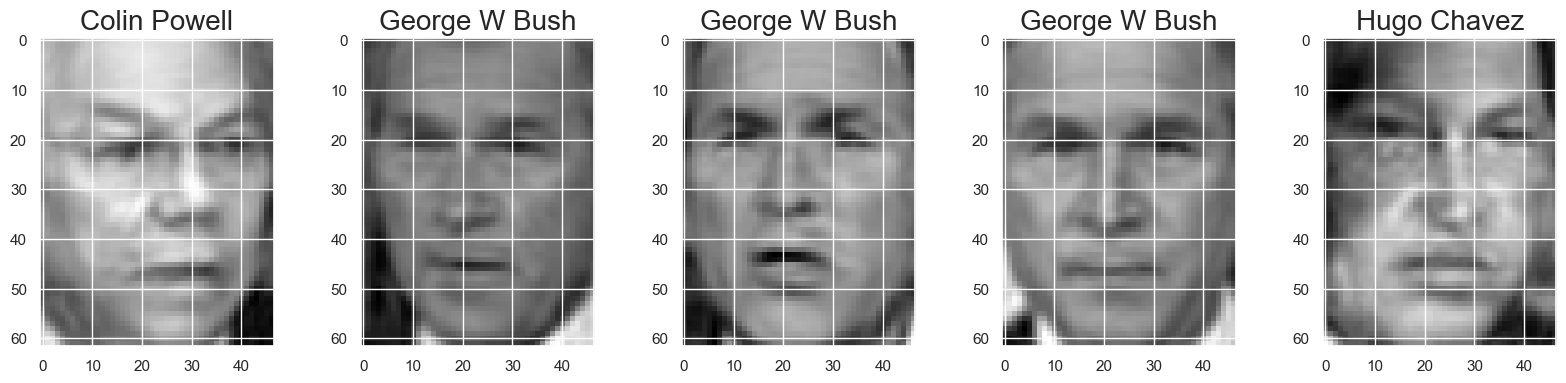

In [196]:
pca = PCA(0.95)
projected = pca.fit_transform(faces.data)
reconstructed = pca.inverse_transform(projected)

plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(reconstructed[0:5], faces.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (62,47)), cmap=plt.cm.gray)
    plt.title(faces.target_names[label], fontsize = 20)
plt.show()